In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pycuda.autoinit
import warnings
import time
import cpuinfo
import os
from pycuda.tools import make_default_context
from pycuda import driver, compiler, tools, gpuarray
warnings.filterwarnings('ignore')

In [2]:
def VECTOR_SUM_GPU(vector, vector_size, bdim=512):
    kernel = '''
        __global__ void PartialVectorSum(const float *input, float *partial_sums, const int n) {
            __shared__ float shared_data[512];
            int tid = threadIdx.x;
            int idx = threadIdx.x + blockIdx.x * blockDim.x;
        
            shared_data[tid] = (idx < n) ? input[idx] : 0.0f;
            __syncthreads();
        
            for (int stride = blockDim.x / 2; stride > 0; stride /= 2) {
                if (tid < stride) {
                    shared_data[tid] += shared_data[tid + stride];
                }
                __syncthreads();
            }
        
            if (tid == 0) {
                partial_sums[blockIdx.x] = shared_data[0];
            }
        }
    '''           

    block_dim = bdim
    grid_dim = (vector_size + block_dim - 1) // block_dim
    partial_sums_gpu = gpuarray.zeros(grid_dim, np.float32)
    
    modules = compiler.SourceModule(kernel)
    modules.get_function('PartialVectorSum')(vector, partial_sums_gpu, np.int32(vector_size), block=(block_dim, 1, 1), grid=(grid_dim, 1, 1))

    return np.sum(partial_sums_gpu.get())

In [3]:
def VECTOR_SUM_CPU(vector):
    result = .0
    for elem in vector:
        result += elem
    return result

In [19]:
VECTOR_SIZE = [1_000, 5_000, 25_000, 50_000, 100_000, 250_000, 500_000, 1_000_000, 10_000_000, 25_000_000]
# VECTOR_SIZE = [100, 10000000, 2000, 5000]  #
TIME_CPU = []
TIME_GPU = []
DIFFERENCE_CPU_GPU = []

print(f'GPU: {tools.make_default_context().get_device().name()}')
print(f'CPU: {cpuinfo.get_cpu_info()["brand_raw"]}')
print()

for size in VECTOR_SIZE:
    # Создаём данные
    np.random.seed(1)
    vector = np.random.randn(size).astype(np.float32)
    
    # Вычисляем время на CPU
    CPU_START = time.time()
    CPU = VECTOR_SUM_CPU(vector)
    CPU_TIME = time.time() - CPU_START
    TIME_CPU.append(CPU_TIME)
    
    # Вычисляем время на GPU
    GPU_START = time.time()
    vector_gpu = gpuarray.to_gpu(vector)
    GPU = VECTOR_SUM_GPU(vector_gpu, size)
    GPU_TIME = time.time() - GPU_START
    TIME_GPU.append(GPU_TIME)
    
    # Вычисляем разницу между CPU & GPU
    DIFFERENCE_TIME = CPU_TIME - GPU_TIME
    DIFFERENCE_CPU_GPU.append(DIFFERENCE_TIME)

    # Проверим разницу
    DIFF = np.max(np.abs(CPU - GPU))
    
    print(f'Размерность матрицы: {size}')
    print(f'Время выполнения на CPU: {CPU_TIME:.3f}')
    print(f'Время выполнения на GPU: {GPU_TIME:.3f}')
    print(f'Разница между CPU & GPU: {DIFFERENCE_TIME:.3f}')
    print(f'Разница: {DIFF:.3f}')
    print()

GPU: Tesla P100-PCIE-16GB
CPU: Intel(R) Xeon(R) CPU @ 2.00GHz

Размерность матрицы: 1000
Время выполнения на CPU: 0.000
Время выполнения на GPU: 0.115
Разница между CPU & GPU: -0.115
Разница: 0.000

Размерность матрицы: 5000
Время выполнения на CPU: 0.001
Время выполнения на GPU: 0.001
Разница между CPU & GPU: 0.000
Разница: 0.000

Размерность матрицы: 25000
Время выполнения на CPU: 0.004
Время выполнения на GPU: 0.001
Разница между CPU & GPU: 0.004
Разница: 0.000

Размерность матрицы: 50000
Время выполнения на CPU: 0.008
Время выполнения на GPU: 0.001
Разница между CPU & GPU: 0.008
Разница: 0.000

Размерность матрицы: 100000
Время выполнения на CPU: 0.017
Время выполнения на GPU: 0.001
Разница между CPU & GPU: 0.017
Разница: 0.000

Размерность матрицы: 250000
Время выполнения на CPU: 0.040
Время выполнения на GPU: 0.001
Разница между CPU & GPU: 0.039
Разница: 0.000

Размерность матрицы: 500000
Время выполнения на CPU: 0.086
Время выполнения на GPU: 0.002
Разница между CPU & GPU: 0.085

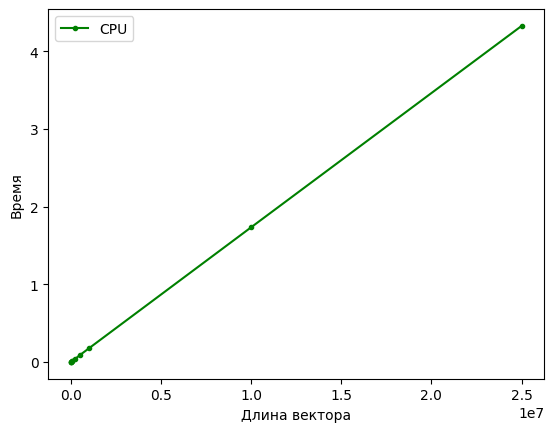

In [20]:
plt.plot(VECTOR_SIZE, TIME_CPU, color='green', label='CPU', marker='.')
plt.xlabel('Длина вектора')
plt.ylabel('Время')
plt.legend()

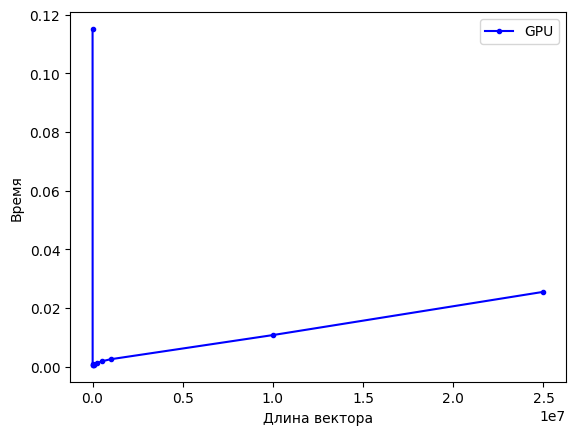

In [21]:
plt.plot(VECTOR_SIZE, TIME_GPU, color='blue', label='GPU', marker='.')
plt.xlabel('Длина вектора')
plt.ylabel('Время')
plt.legend()

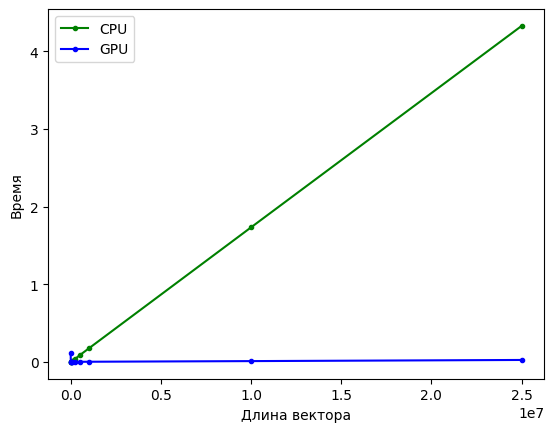

In [22]:
plt.plot(VECTOR_SIZE, TIME_CPU, color='green', label='CPU', marker='.')
plt.plot(VECTOR_SIZE, TIME_GPU, color='blue', label='GPU', marker='.')
plt.xlabel('Длина вектора')
plt.ylabel('Время')
plt.legend()